# Preprocessing of given dataset

Analyzed data is "Air passenger transport between the main airports of Poland and their main partner airports" from Eurostat database.

Source: https://ec.europa.eu/eurostat/web/transport/data/database [31/01/2020]

First step is to import necessary libraries and to upload the .csv file downloaded from Eurostat.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('airplane_data.csv')
df.head()

,TIME,AIRP_PR,TRA_MEAS,UNIT,Value
0,2004M01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Passengers on board,Passenger,:
1,2004M01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Passengers on board,Flight,:
2,2004M01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Commercial passenger air flights,Passenger,:
3,2004M01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Commercial passenger air flights,Flight,:
4,2004M01,BYDGOSZCZ/SZWEDEROWO airport - NIEDERRHEIN air...,Passengers on board,Passenger,:


Meaning of columns:
- TIME is the given month, 
- AIRP_PR is airplane route, 
- TRA_MEAS is the measure of UNIT and 
- VALUE is the number of passengers or flights on given route during one month. The symbol ':' means that the is no data in this record.

At this moment there is only default index. Moreover, AIRP_PR should be split into two columns - the mother airport and the destination in the future analysis. But the next step is to check the detailed info about the data.

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365268 entries, 0 to 365267
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   TIME      365268 non-null  object
 1   AIRP_PR   365268 non-null  object
 2   TRA_MEAS  365268 non-null  object
 3   UNIT      365268 non-null  object
 4   Value     365268 non-null  object
dtypes: object(5)
memory usage: 130.9 MB


The data contains 365268 rows and 5 columns.
Dtypes of every column is 'object', hence the memory usage is significant (130 MB). In order to optimize the analysis process I need to change dtypes of data in columns. 

Checking the number of unique values and changing dtype to category of those columns that has low number of unique values.

In [4]:
df.nunique()

TIME          183
AIRP_PR       499
TRA_MEAS        2
UNIT            2
Value       15459
dtype: int64

In [5]:
df['UNIT'] = df['UNIT'].astype('category')
df['TRA_MEAS'] = df['TRA_MEAS'].astype('category')

Checking the number of missing values.

In [6]:
df.isnull().sum()

TIME        0
AIRP_PR     0
TRA_MEAS    0
UNIT        0
Value       0
dtype: int64

There is no missing values in (as np.nan) in the dataset. But you can see that in case of no values Eurostat uses the colon sign. In order to change Values column to integer (or float in this case) I need to change ":" to np.nan and remove whitespace between the numbers to they can be interpreted as number, not string.

In [7]:
df['Value'].replace(':',np.nan, inplace=True)

In [8]:
df['Value'] = df['Value'].str.replace(' ','')
df['Value'] = df['Value'].astype('float')

Changing dtype of TIME column to datetime.

In [9]:
df['TIME'] = df['TIME'].apply(lambda time: '-'.join(time.split('M')))
df['TIME'] = pd.to_datetime(df['TIME'])

Memory usage after initial optimization has been reduced threefold, which will improve the analysis process.

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365268 entries, 0 to 365267
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   TIME      365268 non-null  datetime64[ns]
 1   AIRP_PR   365268 non-null  object        
 2   TRA_MEAS  365268 non-null  category      
 3   UNIT      365268 non-null  category      
 4   Value     63579 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(1)
memory usage: 43.3 MB


The AIRP_PR column, which indicates the route of the aircraft, is difficult to analyze in its current form.

Split the AIRP_PR column into two separate ones: departure and arrival.

I break it down by 'airport -' because in some airport names there is a dash that can break down into more than two columns and remove the word 'airport' from the second new column.

In [11]:
df[['Departure', 'Arrival']] = df['AIRP_PR'].str.split(' airport - ', expand=True)
df['Arrival'] = df['Arrival'].apply(lambda x: x.replace(' airport', ''))

In [12]:
df.head()

,TIME,AIRP_PR,TRA_MEAS,UNIT,Value,Departure,Arrival
0,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Passengers on board,Passenger,NaN,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN
1,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Passengers on board,Flight,NaN,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN
2,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Commercial passenger air flights,Passenger,NaN,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN
3,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - FRANKFURT/MAIN ...,Commercial passenger air flights,Flight,NaN,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN
4,2004-01-01,BYDGOSZCZ/SZWEDEROWO airport - NIEDERRHEIN air...,Passengers on board,Passenger,NaN,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN


Removal of the previous AIRP_PR column and reordering.

In [13]:
df.drop('AIRP_PR', axis=1, inplace=True)
df = df[['TIME','Departure', 'Arrival', 'TRA_MEAS', 'UNIT', 'Value']]

In [14]:
df.nunique()

TIME           183
Departure       12
Arrival        155
TRA_MEAS         2
UNIT             2
Value        15458
dtype: int64

Splitting AIRP_PR column created new ones with the names of airports. These names repeat multiple times in the dataset (12 and 155), so I can change them from object dtype to category.

As preprocessing is coming to an end - changing names from automatically generated ones to ones that more accurately describe the data contained in them.

In [15]:
df['Departure'] = df['Departure'].astype('category')
df['Arrival'] = df['Arrival'].astype('category')

In [16]:
new_column_names = ['Period', 'Departure', 'Arrival', 'Measure', 'Unit', 'Value']
df.columns = new_column_names
df.head()

,Period,Departure,Arrival,Measure,Unit,Value
0,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Passengers on board,Passenger,NaN
1,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Passengers on board,Flight,NaN
2,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Commercial passenger air flights,Passenger,NaN
3,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Commercial passenger air flights,Flight,NaN
4,2004-01-01,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN,Passengers on board,Passenger,NaN


Very early data analysis indicates that the above data is constructed in such a way that there is a separate row for each case.
The above means that the data generated unnecessarily contains lines that attempt to indicate the number of passengers in the flight values and the number of flights in the passenger values. In such lines, Value is always = np.nan, and the data itself is unnecessarily doubled.

The first step is to create filters that will be used to filter the rows to delete.
Then I remove the filtered rows from the dataset.

In [17]:
measure_flights = df['Measure'] == 'Commercial passenger air flights'
measure_passengers = df['Measure'] == 'Passengers on board'
unit_flights = df['Unit'] == 'Flight'
unit_passengers = df['Unit'] == 'Passenger'

In [18]:
rows_to_remove = df[((measure_flights & unit_passengers) | (measure_passengers & unit_flights))].index.to_list()

In [19]:
df.drop(rows_to_remove, inplace=True)

In [20]:
df.head()

,Period,Departure,Arrival,Measure,Unit,Value
0,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Passengers on board,Passenger,NaN
3,2004-01-01,BYDGOSZCZ/SZWEDEROWO,FRANKFURT/MAIN,Commercial passenger air flights,Flight,NaN
4,2004-01-01,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN,Passengers on board,Passenger,NaN
7,2004-01-01,BYDGOSZCZ/SZWEDEROWO,NIEDERRHEIN,Commercial passenger air flights,Flight,NaN
8,2004-01-01,BYDGOSZCZ/SZWEDEROWO,GIRONA,Passengers on board,Passenger,NaN


It can be seen that the Measure and Unit columns perform the same function - both indicate whether the measured value is the number of flights or passengers in a given case.
Deleting one of them and setting it together with date as multiindex will result in creating two separate data sets combined into one.

In [21]:
df['Measure'].replace('Passengers on board', 'Passengers', inplace=True)
df['Measure'].replace('Commercial passenger air flights', 'Flights', inplace=True)
df = df.drop('Unit', axis=1).set_index(['Measure', 'Period']).sort_index()

In [22]:
df

Departure           Arrival    Value
Measure    Period                                                     
Flights    2004-01-01  BYDGOSZCZ/SZWEDEROWO    FRANKFURT/MAIN      NaN
           2004-01-01  BYDGOSZCZ/SZWEDEROWO       NIEDERRHEIN      NaN
           2004-01-01  BYDGOSZCZ/SZWEDEROWO            GIRONA      NaN
           2004-01-01  BYDGOSZCZ/SZWEDEROWO            DUBLIN      NaN
           2004-01-01  BYDGOSZCZ/SZWEDEROWO  WARSZAWA/CHOPINA      NaN
...                                     ...               ...      ...
Passengers 2019-03-01   WROCLAW/STRACHOWICE     EAST MIDLANDS      NaN
           2019-03-01   WROCLAW/STRACHOWICE           GLASGOW      NaN
           2019-03-01   WROCLAW/STRACHOWICE         EDINBURGH      NaN
           2019-03-01   WROCLAW/STRACHOWICE         PRESTWICK      NaN
           2019-03-01   WROCLAW/STRACHOWICE   LONDON STANSTED  16803.0

[182634 rows x 3 columns]

Finally, before starting actual data analysis, it is a good idea to save the processed data to a new file.

In [23]:
df.to_csv('airplanes_data_processed.csv')

# Analysis and visualization of data

Due to the fact that the data describe the number of passengers and flights from individual Polish airports - I check what is the analyzed period and what airports are located in the studied data.

In [24]:
print("Start of the analyzed period:\t{}".format(df.index.min()[1]))
print("End of the analyzed period:\t{}".format(df.index.max()[1]))

Start of the analyzed period:	2004-01-01 00:00:00
End of the analyzed period:	2019-03-01 00:00:00


In [25]:
df['Departure'].unique()

[BYDGOSZCZ/SZWEDEROWO, GDANSK IM LECHA WALESY, KRAKOW/BALICE, KATOWICE/PYRZOWICE, LUBLIN, ..., POZNAN/LAWICA, RZESZOW/JASIONKA, SZCZECIN/GOLENIOW, WARSZAWA/CHOPINA, WROCLAW/STRACHOWICE]
Length: 12
Categories (12, object): [BYDGOSZCZ/SZWEDEROWO, GDANSK IM LECHA WALESY, KRAKOW/BALICE, KATOWICE/PYRZOWICE, ..., RZESZOW/JASIONKA, SZCZECIN/GOLENIOW, WARSZAWA/CHOPINA, WROCLAW/STRACHOWICE]

In [26]:
df['Arrival'].unique()

[FRANKFURT/MAIN, NIEDERRHEIN, GIRONA, DUBLIN, WARSZAWA/CHOPINA, ..., ODESA, NEWARK LIBERTY INTERNATIONAL, NJ., NEW YORK/JOHN F. KENNEDY INTERNATIONAL, NY., LOS ANGELES INTERNATIONAL, CA., PALERMO/PUNTA RAISI]
Length: 155
Categories (155, object): [FRANKFURT/MAIN, NIEDERRHEIN, GIRONA, DUBLIN, ..., NEWARK LIBERTY INTERNATIONAL, NJ., NEW YORK/JOHN F. KENNEDY INTERNATIONAL, NY., LOS ANGELES INTERNATIONAL, CA., PALERMO/PUNTA RAISI]

Planes take off from 12 Polish airports and land at 155 both Polish and foreign airports. Planes take off from 12 Polish airports and land at 155 Polish and foreign airports.

In [27]:
df.loc['Flights'].describe()

,Value
count,31785.000000
mean,95.561334
std,121.924823
min,1.000000
25%,26.000000
50%,46.000000
75%,122.000000
max,4964.000000


In [28]:
most_flights = df['Value'] == df['Value'].loc['Flights'].max() #filter
df[most_flights].loc['Flights']
#cannot use idxmax() function due to the fact that would only show date, not actual route

,Departure,Arrival,Value
Period,,,
2006-04-01,KRAKOW/BALICE,BOLOGNA/BORGO PANIGALE,4964.0


Route with the most flights in one month was Kraków - Bologna in April 2006 -  almost 5000 aircraft flew to Bologna.

In [29]:
df.loc['Passengers']['Value'].mean()

8693.782820657985

As for the number of passengers, the average number of passengers on one route within a month period was 8693.

One may wonder which of the Polish airports had the largest number of aircraft departed during the analyzed period. To get this information, it is necessary to group the data by column 'Departure'.

In [30]:
df_flights = df.loc['Flights'].groupby(['Departure'])

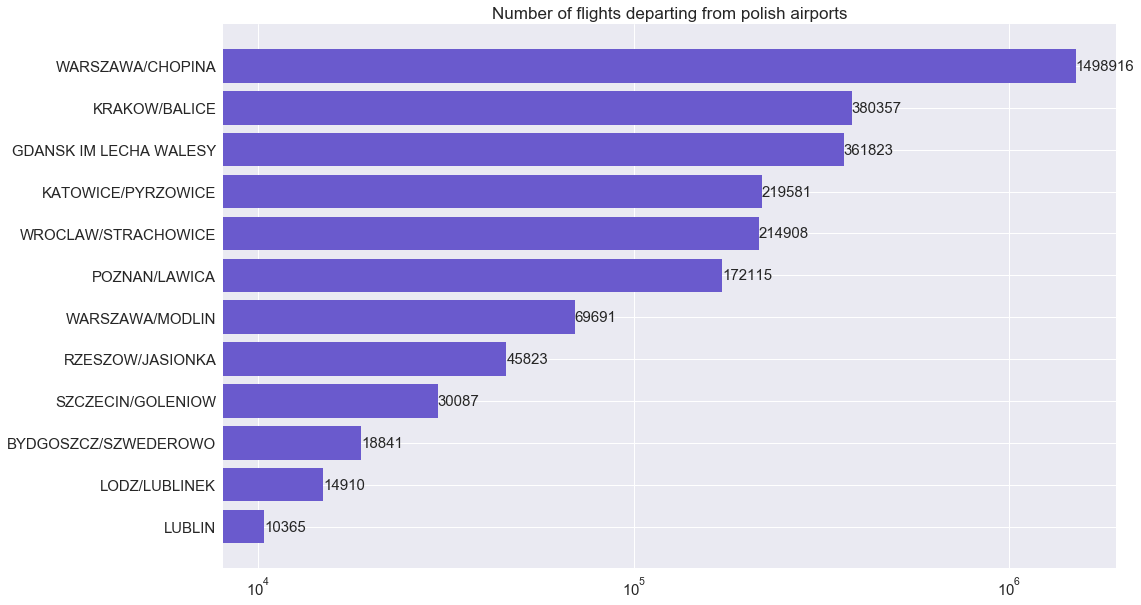

In [31]:
bar_chart = df_flights.sum().sort_values('Value')

#Set seaborn to make charts look better. 
#It is enough to set it only once in the course of the analyzed data, 
#the change applies to each subsequent chart.
plt.style.use('seaborn') 

plt.figure(figsize=(16,10))
bars = plt.barh(bar_chart.index, bar_chart['Value'], log=True, color='slateblue')

#The chart uses a logarithmic scale with respect to the Y axis, because the data on 
#the airport with the largest number of departures differ radically from
#the one with the smallest number - this will allow for better arrangement of data on the chart.

plt.tick_params('both', labelsize=15)
plt.title('Number of flights departing from polish airports', fontdict={'fontsize':17})

for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + 0.3, int(xval), fontsize=15)

The graph shows that Warsaw Chopin Airport serves the largest number of flights. At the same time one can see that Lublin airport is not very popular and the number of flights deprating from Warsaw Chopin Airport is almost 145 times bigger.

Another thing you can study is the evolution of the number of passengers over time at a given airport. Take the Krakow airport as an example.

In [32]:
#filtering data so that it only contains the number of passengers and the airport in Krakow.
krakow_pass_filter = df[df['Departure']=='KRAKOW/BALICE'].loc['Passengers'] 

#creating yearly bins to cut data
yearly_bins = pd.date_range('2004-01-01', periods=16, freq='YS')

In [33]:
krakow_pass = krakow_pass_filter.groupby(pd.cut(
    krakow_pass_filter.index, yearly_bins, right=False)).sum()
krakow_pass

,Value
"[2004-01-01, 2005-01-01)",0.0
"[2005-01-01, 2006-01-01)",0.0
"[2006-01-01, 2007-01-01)",2166217.0
"[2007-01-01, 2008-01-01)",2188780.0
"[2008-01-01, 2009-01-01)",2369201.0
"[2009-01-01, 2010-01-01)",2038303.0
"[2010-01-01, 2011-01-01)",2157216.0
"[2011-01-01, 2012-01-01)",2391760.0
"[2012-01-01, 2013-01-01)",2635381.0
"[2013-01-01, 2014-01-01)",2780391.0


For some reason, you can see that there is a lack of data - for this reason, the chart should be narrowed so the period excludes the first two years.

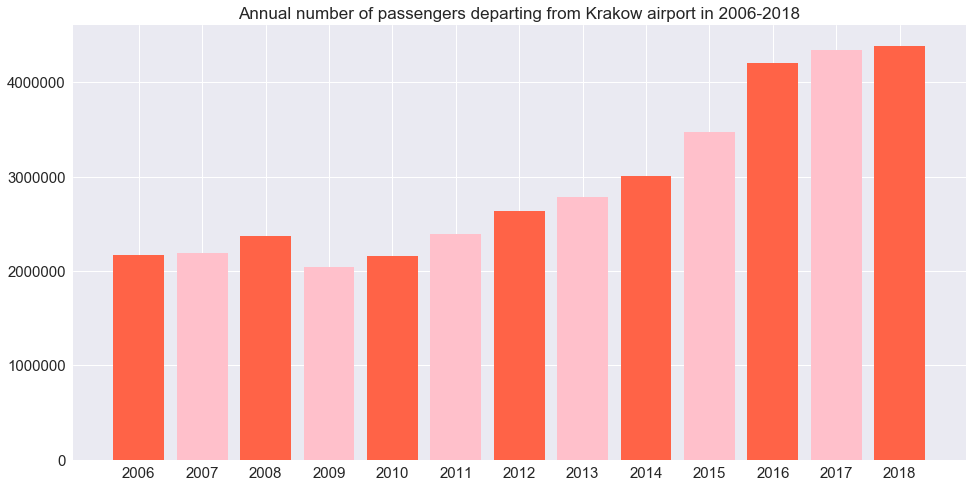

In [34]:
#creating labels for the X axis
labels_dates = [year for year in range(2006,2019)]

plt.figure(figsize=(16,8))
plt.bar(labels_dates, krakow_pass['Value'][2:], color=['tomato', 'pink'])
plt.title('Annual number of passengers departing from Krakow airport in 2006-2018', fontdict={'fontsize':17})
plt.xticks(labels_dates)
plt.tick_params('both', labelsize=15)

The diagram shows that the number of passengers increased during the analyzed period - with a slight decrease in 2009 - the decrease may be associated with  the financial crisis.

Another thing you can examine on the data is the popularity of a given direction among passengers.

In [35]:
#creating pivot table to sum the number of passengers
dest_pop = df.loc['Passengers'].pivot_table(index='Arrival', aggfunc='sum')

#creating additional columns containing information on the 
#share of passengers using a given airport in the total number of passengers
#departing from Poland and creating their ranking
dest_pop['Percentage'] = (dest_pop['Value'] / dest_pop['Value'].sum()).apply('{:.3%}'.format)
dest_pop['Ranking'] = dest_pop['Value'].rank(ascending=False, method='max')
dest_pop = dest_pop.sort_values('Ranking')
dest_pop['Value'] = dest_pop['Value'].astype('int')

In [36]:
dest_pop.head(10)

,Value,Percentage,Ranking
Arrival,,,
LONDON STANSTED,17184227,6.217%,1.0
LONDON LUTON,15686213,5.675%,2.0
WARSZAWA/CHOPINA,15321599,5.543%,3.0
FRANKFURT/MAIN,14479253,5.238%,4.0
MUENCHEN,11316432,4.094%,5.0
DUBLIN,9307740,3.367%,6.0
PARIS-CHARLES DE GAULLE,8072386,2.920%,7.0
LONDON HEATHROW,6345988,2.296%,8.0
AMSTERDAM/SCHIPHOL,6068161,2.195%,9.0


As can be seen in the table above - the top 10 most popular destination among passengers - only one airport is located in Poland, which means that the main directions are foreign airports.

Looking at these data, you can think about the share of domestic flights in total flights. Firstly, an additional column is added specifying whether a given flight should be categorized as demestic or international. As there may only be two types - category dtype is being applied.

In [37]:
df['Form of flight'] = df['Arrival'].apply(
    lambda airport: 'Domestic' if airport in df['Departure'].unique() else 'International')
df['Form of flight'] = df['Form of flight'].astype('category')

In [38]:
df.head()

Departure           Arrival  Value  \
Measure Period                                                      
Flights 2004-01-01  BYDGOSZCZ/SZWEDEROWO    FRANKFURT/MAIN    NaN   
        2004-01-01  BYDGOSZCZ/SZWEDEROWO       NIEDERRHEIN    NaN   
        2004-01-01  BYDGOSZCZ/SZWEDEROWO            GIRONA    NaN   
        2004-01-01  BYDGOSZCZ/SZWEDEROWO            DUBLIN    NaN   
        2004-01-01  BYDGOSZCZ/SZWEDEROWO  WARSZAWA/CHOPINA    NaN   

                   Form of flight  
Measure Period                     
Flights 2004-01-01  International  
        2004-01-01  International  
        2004-01-01  International  
        2004-01-01  International  
        2004-01-01       Domestic

Let's see the proportion of domestic and international flights in 2012 and show this on the pie chart.

In [39]:
#creating additional filter to exclude rows, where Value in np.nan
na_values = df['Value'].isnull()  

#creating date range of 12 months in 2012
one_year = pd.date_range('2012-01-01', periods=12, freq='MS') #pierwsze dni miesięcy danego roku

forms_single = df[~na_values].loc['Flights', one_year, :]['Form of flight'].value_counts()
forms_single

International    2046
Domestic          240
Name: Form of flight, dtype: int64

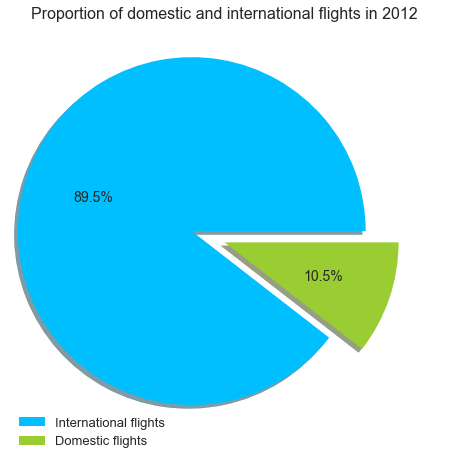

In [40]:
forms_single.plot(kind='pie', subplots=True, figsize=(8,8), autopct='%.1f%%', fontsize=14,
       colors=['deepskyblue', 'yellowgreen'], legend=True, explode=(0.2,0), labeldistance=None,
       labels=['International flights', 'Domestic flights'], shadow=True)
plt.legend(prop={'size':13})
plt.title('Proportion of domestic and international flights in 2012', fontdict={'fontsize':16})
plt.axis('off')
plt.show()

As can be seen, foreign flights are definitely more frequent than domestic flights. However, the data show information for a given year, which says nothing about how this proportion changes over time.

In [41]:
flight_forms = df[~na_values].loc['Flights']['Form of flight']
forms_df = flight_forms.groupby(pd.cut(
    flight_forms.index, yearly_bins, right=False)).value_counts().to_frame()

In [42]:
forms_df['Percentage'] = forms_df.groupby(level=0).transform(lambda x: (x / x.sum()).round(3))
forms_df.rename({'Form of flight' : 'Number of flights'}, axis=1, inplace=True)

In [43]:
forms_df.head()

Number of flights  Percentage
                         Form of flight                               
[2004-01-01, 2005-01-01) International                 276       0.821
                         Domestic                       60       0.179
[2005-01-01, 2006-01-01) International                 288       0.828
                         Domestic                       60       0.172
[2006-01-01, 2007-01-01) International                1165       0.902

By using the pd.cut() function and data grouping, a table showing the evolution of share of domestic and foreign flights over time can be created.

Additional display on the chart may facilitate reading the trend.

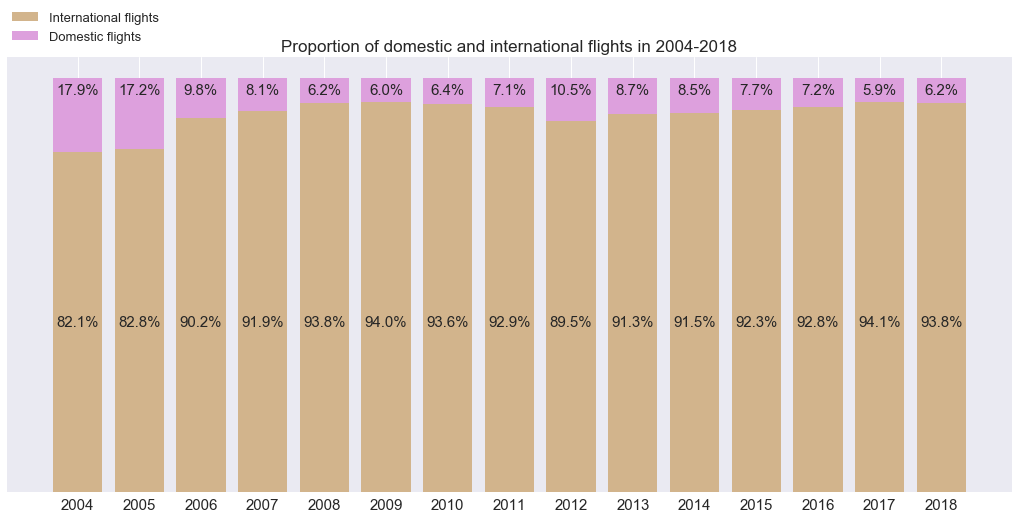

In [44]:
#creating additional filters
inter = forms_df.index.get_level_values(1) == 'International'
domes = forms_df.index.get_level_values(1) == 'Domestic'

labels_dates = [year for year in range(2004,2019)]

plt.figure(figsize=(18,8))

#creating bar charts separately and placing them on each other
bar1 = plt.bar(labels_dates, forms_df[inter]['Percentage'], label='International flights',
              color='tan')
bar2 = plt.bar(labels_dates, forms_df[domes]['Percentage'], bottom=forms_df[inter]['Percentage'],
              label='Domestic flights', color='plum')

plt.xticks(labels_dates)
plt.tick_params('both', labelsize=15)
plt.title('Proportion of domestic and international flights in 2004-2018', fontdict={'fontsize':17})
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), 
           loc='lower left',mode="expand", borderaxespad=0., prop={'size':13})
plt.yticks([])

#inputting data on the chart
for r1, r2 in zip(bar1, bar2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x()+r1.get_width()/2, 0.4, '{:.1%}'.format(h1), ha="center", fontsize=15)
    plt.text(r2.get_x()+r2.get_width()/2, 0.96 ,'{:.1%}'.format(h2), ha="center", fontsize=15)

Another, in this case the last thing, is to show the line graph of the number of passengers on a given route. Take the number of passengers on the route from Warsaw Chopin Airport to Frankfurt as an example.

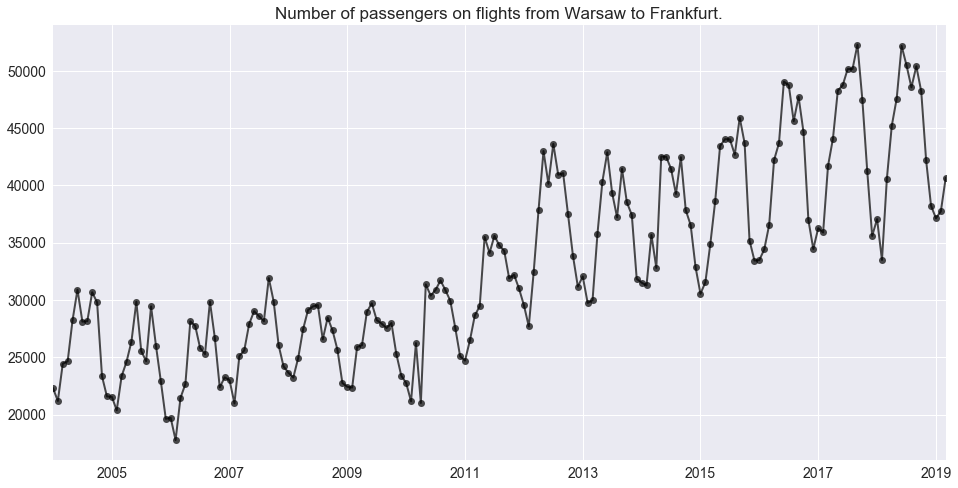

In [45]:
#creating additional filters
warsaw = df['Departure'] == 'WARSZAWA/CHOPINA'
frankfurt = df['Arrival'] == "FRANKFURT/MAIN"

#grouping and summing data
war_fra = df[warsaw & frankfurt].loc['Passengers'].groupby(level=0).sum()

war_fra.plot(style='-ko', figsize=(16,8), legend=None, lw=2, markersize=7, alpha=0.7)

plt.title('Number of passengers on flights from Warsaw to Frankfurt.',fontdict={'fontsize':17})
plt.xlabel("")
plt.tick_params('both', labelsize=14)

As can be seen on the graph, the number of passengers differs over time and shows seasonality in the period of 12 months. The future numbers may be crucial for airports to estimate future demand. 

# Simple data forcasting with ARIMA model

In this analysis, the prediction of future passenger numbers on the Warsaw - Franfurt route will be based solely on historical data. It should be noted, however, that the exact number also depends on external factors, including such as financial situations or the number of seats avaible on planes.

In [46]:
war_fra.columns = ['Passengers']

In [47]:
war_fra.head()

,Passengers
Period,
2004-01-01,22316.0
2004-02-01,21191.0
2004-03-01,24437.0
2004-04-01,24653.0
2004-05-01,28245.0


The chart in the previous section of the analysis shows that the data examined may be seasonal. To confirm this, the time series will be decomposed.

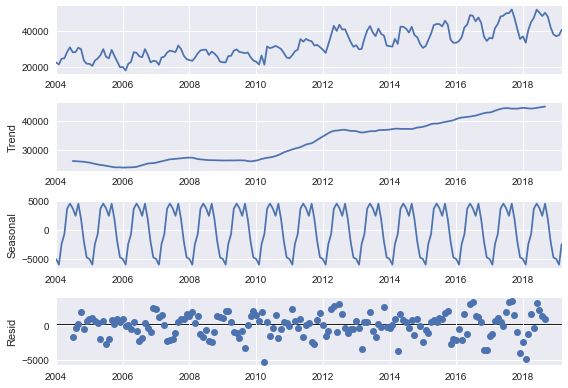

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(war_fra, model='additive').plot()

It has been confirmed that the data are seasonal with a clear trend line.
However, this means that the data is not stationary - an Augmented Dickey-Fuller test to confirm this is being created.

In [49]:
import statsmodels.api as sm

def adf(item):
    result = sm.tsa.stattools.adfuller(item)
    labels = ['ADF Test Statistics', 'p-value', 'Number of lags', 'Number of observations']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
    if result[1] <= 0.05:
        print('\nData is stationary')
    else:
        print('\nData is non-stationary')

In [50]:
adf(war_fra['Passengers'])

ADF Test Statistics: 0.022533643370150933
p-value: 0.9603564013050216
Number of lags: 14
Number of observations: 168

Data is non-stationary


The ADF test confirms that the original data is non-stationary. Because they have a seasonal character, a seasonal difference is created first, i.e. 12 months. If the seasonal difference is stationary, then it will be used to forecast data.

In [51]:
war_fra['Seasonal difference'] = war_fra['Passengers'] - war_fra['Passengers'].shift(12)
adf(war_fra['Seasonal difference'].dropna())

ADF Test Statistics: -2.6264250329929713
p-value: 0.087657805613851
Number of lags: 13
Number of observations: 157

Data is non-stationary


Seasonal difference is still not stationary so Seasonal first difference will be created.

In [52]:
war_fra['First difference'] = war_fra['Passengers'] - war_fra['Passengers'].shift(1)
war_fra['Seasonal first difference'] = war_fra['First difference'] - war_fra['First difference'].shift(12)
adf(war_fra['Seasonal first difference'].dropna())

ADF Test Statistics: -5.503044488908393
p-value: 2.0507803198854452e-06
Number of lags: 12
Number of observations: 157

Data is stationary


Seasonal first difference is stationary and can be used to predict future data. The transformed data chart is also created below - it shows that the data no longer has a trend.

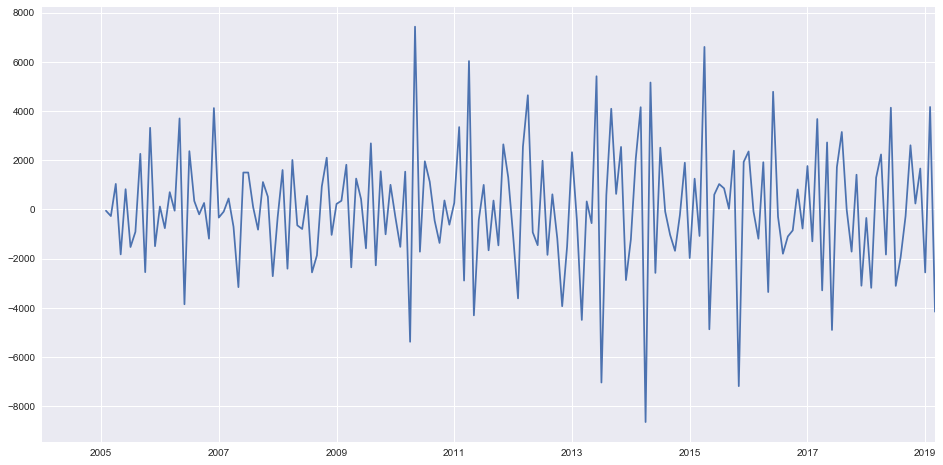

In [53]:
war_fra['Seasonal first difference'].plot(figsize=(16,8))
plt.xlabel('')
plt.show()

In [54]:
war_fra.head(24)

,Passengers,Seasonal difference,First difference,Seasonal first difference
Period,,,,
2004-01-01,22316.0,NaN,NaN,NaN
2004-02-01,21191.0,NaN,-1125.0,NaN
2004-03-01,24437.0,NaN,3246.0,NaN
2004-04-01,24653.0,NaN,216.0,NaN
2004-05-01,28245.0,NaN,3592.0,NaN
2004-06-01,30888.0,NaN,2643.0,NaN
2004-07-01,28112.0,NaN,-2776.0,NaN
2004-08-01,28149.0,NaN,37.0,NaN
2004-09-01,30667.0,NaN,2518.0,NaN


The purpose of this analysis is not to go into advanced econometric models in detail, so in this case a function will be used that automatically calculates the appropriate parameters for the Seasonal ARIMA model, which will be used to predict future number of passengers in the time series. 

In [55]:
from pmdarima import auto_arima

auto_model = auto_arima(war_fra['Passengers'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
        start_P=0, seasonal=True, d=1, D=1, trace=True,  suppress_warnings=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3083.023, BIC=3098.702, Fit time=1.010 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3151.578, BIC=3157.850, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3103.677, BIC=3116.220, Fit time=0.138 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3082.623, BIC=3095.166, Fit time=0.436 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3149.581, BIC=3152.717, Fit time=0.028 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3113.915, BIC=3123.322, Fit time=0.060 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3077.701, BIC=3093.380, Fit time=0.956 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3099.088, BIC=3111.631, Fit time=0.163 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3079.578, BIC=3098.393, Fit time=1.961 seconds
Fit ARIMA: order=(0, 1, 1) s

In [56]:
auto_model.aic()
#Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3075.834, BIC=3091.513, Fit time=2.153 seconds

3075.833766652833

According to the Akaike information criterion, the best parameters are: order = (0, 1, 1) seasonal_order = (0, 1, 2, 12). Generally speaking, the smaller the score (Akaike) is, the better for the model.

Automatically selected parameters seem to make sense, so the model will be created below.

In [57]:
model = sm.tsa.statespace.SARIMAX(war_fra['Passengers'], order=(0,1,1), 
                                  seasonal_order=(0,1,2,12), freq='MS')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [58]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              Passengers   No. Observations:                  183
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1534.764
Date:                                 Sun, 15 Mar 2020   AIC                           3077.528
Time:                                         21:41:21   BIC                           3090.071
Sample:                                     01-01-2004   HQIC                          3082.618
                                          - 03-01-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3988      0.044     -9.099      0.000      -0.485      -0.313
ma.S.L12      -0.4402      0.081     -5.447      0.000      -0.599      -0.282
ma.S.L24      -0.1847      0.065     -2.830      0.005      -0.313      -0.057
sigma2      4.634e+06   5.85e+05      7.916      0.000    3.49e+06    5.78e+06
===================================================================================
Ljung-Box (Q):                       45.63   Jarque-Bera (JB):                 2.34
Prob(Q):                              0.25   Prob(JB):                         0.31
Heteroskedasticity (H):               1.32   Skew:                            -0.04
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

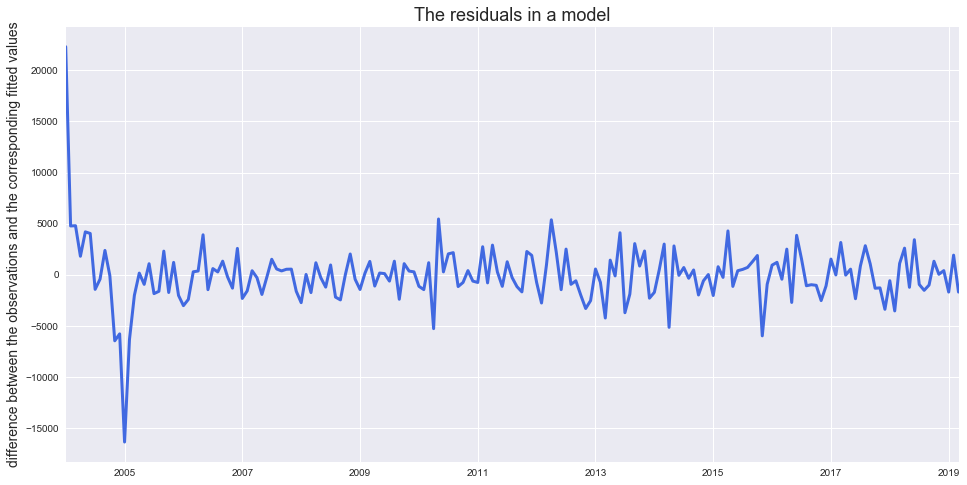

In [59]:
results.resid.plot(figsize=(16,8), lw=3, color='royalblue')
plt.xlabel('')
plt.ylabel('difference between the observations and the corresponding fitted values', size=14)
plt.title('The residuals in a model', size=18)
plt.show()

The residuals in a time series model are what is left over after fitting a model. As can be seen in the graph above, the fit seems good enough, the mean of residuals seems to be close to zero. Hence, the model seems to be fit.

It is possible to forecast some data on the historic data to find how good the model can predict. In this example the model will try to forecast last 2 years of data on the basis of historic data without those two last years.

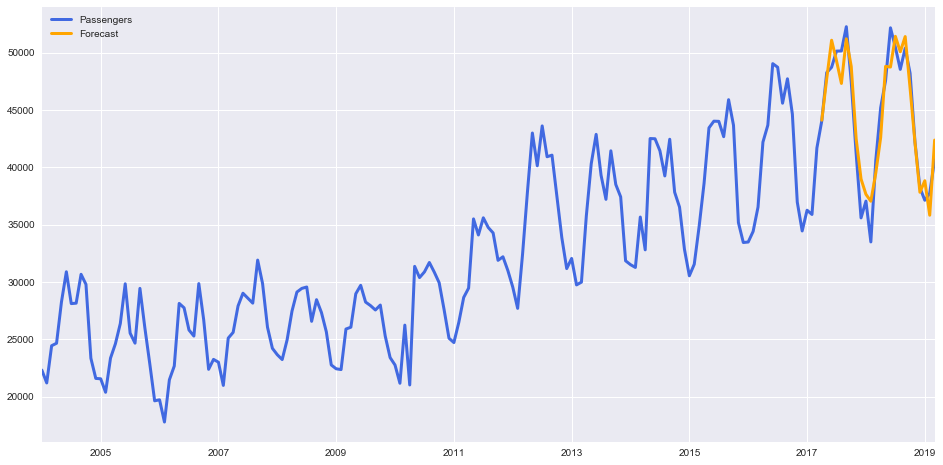

In [60]:
war_fra['Forecast'] = results.predict(start=len(war_fra)-24, end=len(war_fra))
war_fra[['Passengers', 'Forecast']].plot(figsize=(16,8), lw=3, color=['royalblue', 'orange'])
plt.xlabel('')
plt.show()

As you can see in the chart above, the forecast data overlaps to a large extent with the actual data.

This time the forecast will concern the next 3 years. First, an additional table is created in which the new data will be found. This table is than attached to the previous one.

In [61]:
from pandas.tseries.offsets import DateOffset

#creating new dataFrame
future_dates = [war_fra.index[-1] + DateOffset(months=x) for x in range(1, 36)]
future_war_fra = pd.DataFrame(index=future_dates, columns=war_fra.columns)
future_war_fra.head()

,Passengers,Seasonal difference,First difference,Seasonal first difference,Forecast
2019-04-01,NaN,NaN,NaN,NaN,NaN
2019-05-01,NaN,NaN,NaN,NaN,NaN
2019-06-01,NaN,NaN,NaN,NaN,NaN
2019-07-01,NaN,NaN,NaN,NaN,NaN
2019-08-01,NaN,NaN,NaN,NaN,NaN


In [62]:
#attaching new dataFrame 
war_fra = pd.concat([war_fra, future_war_fra])
war_fra.tail()

,Passengers,Seasonal difference,First difference,Seasonal first difference,Forecast
2021-10-01,NaN,NaN,NaN,NaN,NaN
2021-11-01,NaN,NaN,NaN,NaN,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN
2022-01-01,NaN,NaN,NaN,NaN,NaN
2022-02-01,NaN,NaN,NaN,NaN,NaN


In [63]:
#predicting values for the next 3 years
war_fra['Forecast'] = results.predict(start=182, end=183+36)
war_fra['Forecast'][183:].head()

2019-04-01    45251.027503
2019-05-01    48516.388124
2019-06-01    51868.548762
2019-07-01    50860.785089
2019-08-01    48982.027648
Name: Forecast, dtype: float64

Forecasting is over. Now war_fra dataframe includes forecasted values for subsequent years, which can be used by analysts to determine the future value of demand.

For better visualization and understanding, data from the Seasonal ARIMA model is plotted in orange on the chart below.

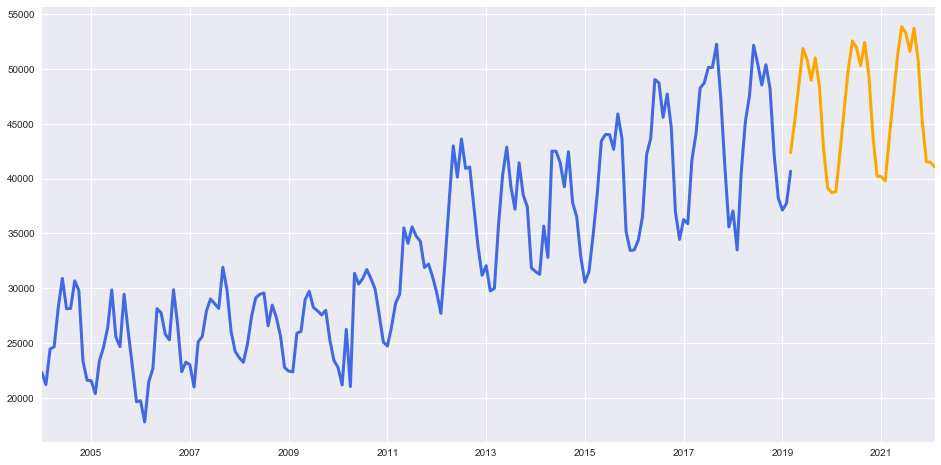

In [64]:
war_fra['Passengers'].plot(figsize=(16,8), lw=3, color='royalblue')
war_fra['Forecast'].plot(color='orange', lw=3)
plt.show()

# Thank you very much! :)